# Plotting means and error bars (ggplot2)
Credits: http://www.cookbook-r.com/ (Creative Commons Attribution-Share Alike 3.0 Unported License)

## Problem
You want to plot means and error bars for a dataset.

## Solution
To make graphs with ggplot2, the data must be in a data frame, and in “long” (as opposed to wide) format. If your data needs to be restructured, see this page for more information.

### Sample data

The examples below will the *ToothGrowth* dataset. Note that dose is a numeric column here; in some situations it may be useful to convert it to a factor.

In [1]:
tg <- ToothGrowth
head(tg)
#>    len supp dose
#> 1  4.2   VC  0.5
#> 2 11.5   VC  0.5
#> 3  7.3   VC  0.5
#> 4  5.8   VC  0.5
#> 5  6.4   VC  0.5
#> 6 10.0   VC  0.5

,len,supp,dose
1,4.2,VC,0.5
2,11.5,VC,0.5
3,7.3,VC,0.5
4,5.8,VC,0.5
5,6.4,VC,0.5
6,10,VC,0.5


In [2]:
# use the ggplot2 library in this notebook
library(ggplot2)

First, it is necessary to summarize the data. This can be done in a number of ways, as described in the "Summarizing Data"-tutorial. In this case, we’ll use the `summarySE()` function defined in the next codecell, aswell as two other helper functions.

In [3]:
## Gives count, mean, standard deviation, standard error of the mean, and confidence interval (default 95%).
##   data: a data frame.
##   measurevar: the name of a column that contains the variable to be summariezed
##   groupvars: a vector containing names of columns that contain grouping variables
##   na.rm: a boolean that indicates whether to ignore NA's
##   conf.interval: the percent range of the confidence interval (default is 95%)
summarySE <- function(data=NULL, measurevar, groupvars=NULL, na.rm=FALSE,
                      conf.interval=.95, .drop=TRUE) {
    library(plyr)

    # New version of length which can handle NA's: if na.rm==T, don't count them
    length2 <- function (x, na.rm=FALSE) {
        if (na.rm) sum(!is.na(x))
        else       length(x)
    }

    # This does the summary. For each group's data frame, return a vector with
    # N, mean, and sd
    datac <- ddply(data, groupvars, .drop=.drop,
      .fun = function(xx, col) {
        c(N    = length2(xx[[col]], na.rm=na.rm),
          mean = mean   (xx[[col]], na.rm=na.rm),
          sd   = sd     (xx[[col]], na.rm=na.rm)
        )
      },
      measurevar
    )

    # Rename the "mean" column    
    datac <- rename(datac, c("mean" = measurevar))

    datac$se <- datac$sd / sqrt(datac$N)  # Calculate standard error of the mean

    # Confidence interval multiplier for standard error
    # Calculate t-statistic for confidence interval: 
    # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
    ciMult <- qt(conf.interval/2 + .5, datac$N-1)
    datac$ci <- datac$se * ciMult

    return(datac)
}

In [4]:
## Norms the data within specified groups in a data frame; it normalizes each
## subject (identified by idvar) so that they have the same mean, within each group
## specified by betweenvars.
##   data: a data frame.
##   idvar: the name of a column that identifies each subject (or matched subjects)
##   measurevar: the name of a column that contains the variable to be summariezed
##   betweenvars: a vector containing names of columns that are between-subjects variables
##   na.rm: a boolean that indicates whether to ignore NA's
normDataWithin <- function(data=NULL, idvar, measurevar, betweenvars=NULL,
                           na.rm=FALSE, .drop=TRUE) {
    library(plyr)

    # Measure var on left, idvar + between vars on right of formula.
    data.subjMean <- ddply(data, c(idvar, betweenvars), .drop=.drop,
     .fun = function(xx, col, na.rm) {
        c(subjMean = mean(xx[,col], na.rm=na.rm))
      },
      measurevar,
      na.rm
    )

    # Put the subject means with original data
    data <- merge(data, data.subjMean)

    # Get the normalized data in a new column
    measureNormedVar <- paste(measurevar, "_norm", sep="")
    data[,measureNormedVar] <- data[,measurevar] - data[,"subjMean"] +
                               mean(data[,measurevar], na.rm=na.rm)

    # Remove this subject mean column
    data$subjMean <- NULL

    return(data)
}

In [5]:
## Summarizes data, handling within-subjects variables by removing inter-subject variability.
## It will still work if there are no within-S variables.
## Gives count, un-normed mean, normed mean (with same between-group mean),
##   standard deviation, standard error of the mean, and confidence interval.
## If there are within-subject variables, calculate adjusted values using method from Morey (2008).
##   data: a data frame.
##   measurevar: the name of a column that contains the variable to be summariezed
##   betweenvars: a vector containing names of columns that are between-subjects variables
##   withinvars: a vector containing names of columns that are within-subjects variables
##   idvar: the name of a column that identifies each subject (or matched subjects)
##   na.rm: a boolean that indicates whether to ignore NA's
##   conf.interval: the percent range of the confidence interval (default is 95%)
summarySEwithin <- function(data=NULL, measurevar, betweenvars=NULL, withinvars=NULL,
                            idvar=NULL, na.rm=FALSE, conf.interval=.95, .drop=TRUE) {

  # Ensure that the betweenvars and withinvars are factors
  factorvars <- vapply(data[, c(betweenvars, withinvars), drop=FALSE],
    FUN=is.factor, FUN.VALUE=logical(1))

  if (!all(factorvars)) {
    nonfactorvars <- names(factorvars)[!factorvars]
    message("Automatically converting the following non-factors to factors: ",
            paste(nonfactorvars, collapse = ", "))
    data[nonfactorvars] <- lapply(data[nonfactorvars], factor)
  }

  # Get the means from the un-normed data
  datac <- summarySE(data, measurevar, groupvars=c(betweenvars, withinvars),
                     na.rm=na.rm, conf.interval=conf.interval, .drop=.drop)

  # Drop all the unused columns (these will be calculated with normed data)
  datac$sd <- NULL
  datac$se <- NULL
  datac$ci <- NULL

  # Norm each subject's data
  ndata <- normDataWithin(data, idvar, measurevar, betweenvars, na.rm, .drop=.drop)

  # This is the name of the new column
  measurevar_n <- paste(measurevar, "_norm", sep="")

  # Collapse the normed data - now we can treat between and within vars the same
  ndatac <- summarySE(ndata, measurevar_n, groupvars=c(betweenvars, withinvars),
                      na.rm=na.rm, conf.interval=conf.interval, .drop=.drop)

  # Apply correction from Morey (2008) to the standard error and confidence interval
  #  Get the product of the number of conditions of within-S variables
  nWithinGroups    <- prod(vapply(ndatac[,withinvars, drop=FALSE], FUN=nlevels,
                           FUN.VALUE=numeric(1)))
  correctionFactor <- sqrt( nWithinGroups / (nWithinGroups-1) )

  # Apply the correction factor
  ndatac$sd <- ndatac$sd * correctionFactor
  ndatac$se <- ndatac$se * correctionFactor
  ndatac$ci <- ndatac$ci * correctionFactor

  # Combine the un-normed means with the normed results
  merge(datac, ndatac)
}

In [6]:
# summarySE provides the standard deviation, standard error of the mean, and a (default 95%) confidence interval
tgc <- summarySE(tg, measurevar="len", groupvars=c("supp","dose"))
tgc

,supp,dose,N,len,sd,se,ci
1,OJ,0.5,10,13.23,4.459709,1.410284,3.190283
2,OJ,1,10,22.7,3.910953,1.236752,2.797727
3,OJ,2,10,26.06,2.655058,0.8396031,1.899314
4,VC,0.5,10,7.98,2.746634,0.868562,1.964824
5,VC,1,10,16.77,2.515309,0.7954104,1.799343
6,VC,2,10,26.14,4.797731,1.517176,3.43209


## Line graphs

After the data is summarized, we can make the graph. These are basic line and point graph with error bars representing either the standard error of the mean, or 95% confidence interval.

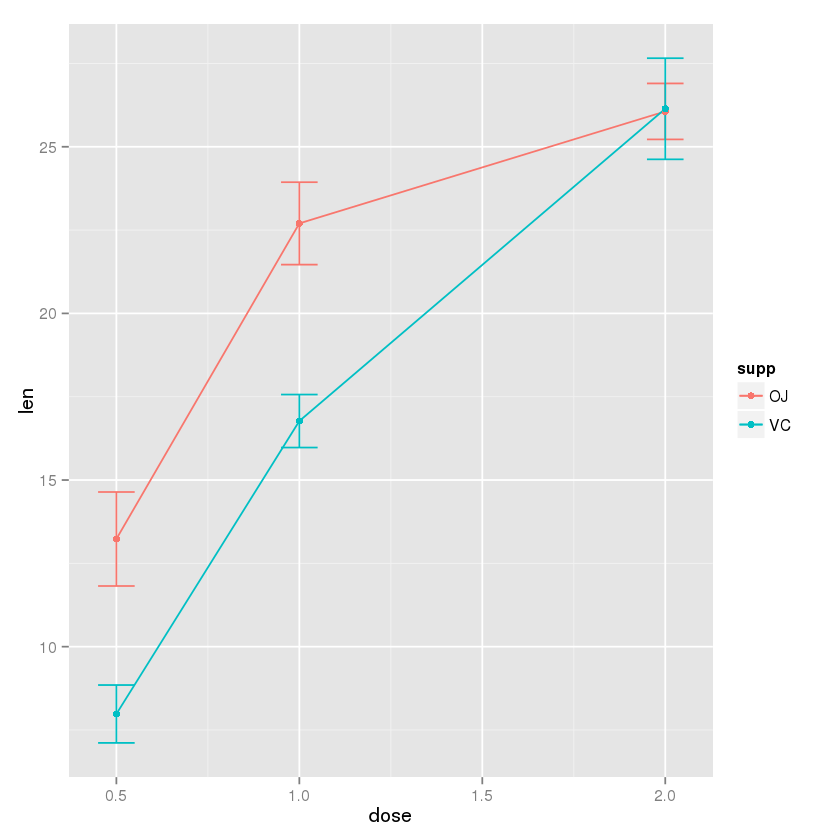

In [7]:
# Standard error of the mean
ggplot(tgc, aes(x=dose, y=len, colour=supp)) + 
    geom_errorbar(aes(ymin=len-se, ymax=len+se), width=.1) +
    geom_line() +
    geom_point()

ymax not defined: adjusting position using y instead
ymax not defined: adjusting position using y instead


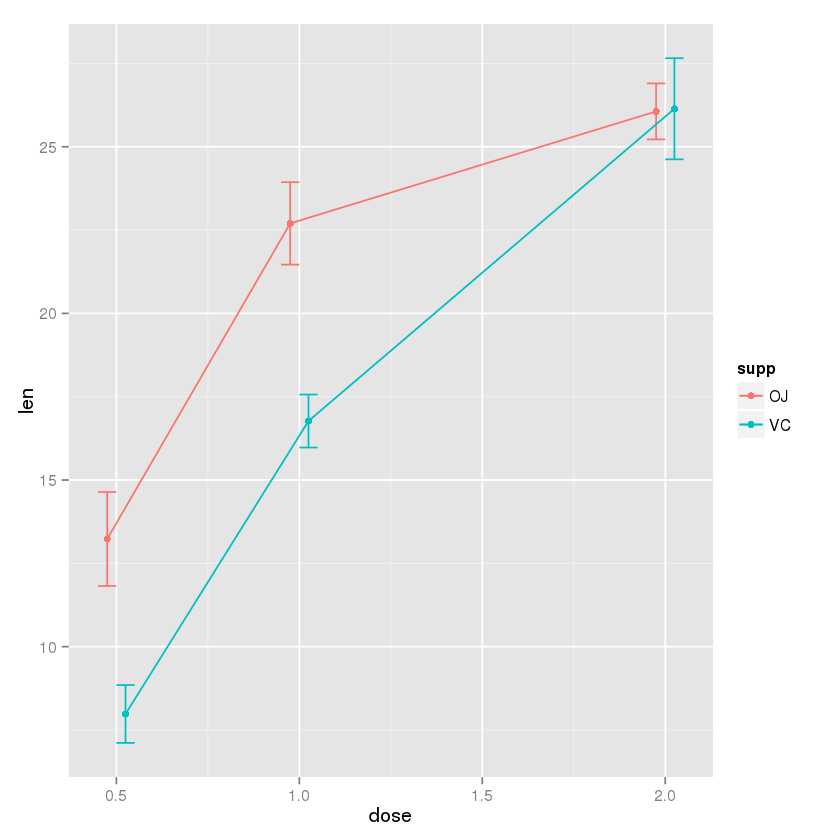

In [8]:
# The errorbars overlapped, so use position_dodge to move them horizontally
pd <- position_dodge(0.1) # move them .05 to the left and right

ggplot(tgc, aes(x=dose, y=len, colour=supp)) + 
    geom_errorbar(aes(ymin=len-se, ymax=len+se), width=.1, position=pd) +
    geom_line(position=pd) +
    geom_point(position=pd)

ymax not defined: adjusting position using y instead
ymax not defined: adjusting position using y instead


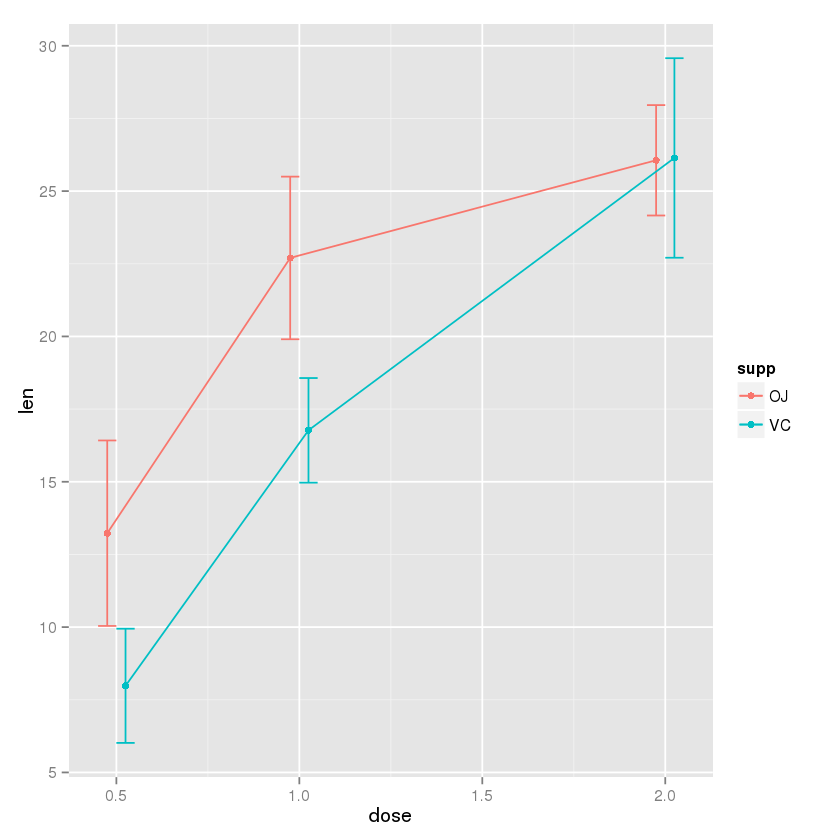

In [9]:
# Use 95% confidence interval instead of SEM
ggplot(tgc, aes(x=dose, y=len, colour=supp)) + 
    geom_errorbar(aes(ymin=len-ci, ymax=len+ci), width=.1, position=pd) +
    geom_line(position=pd) +
    geom_point(position=pd)

ymax not defined: adjusting position using y instead
ymax not defined: adjusting position using y instead


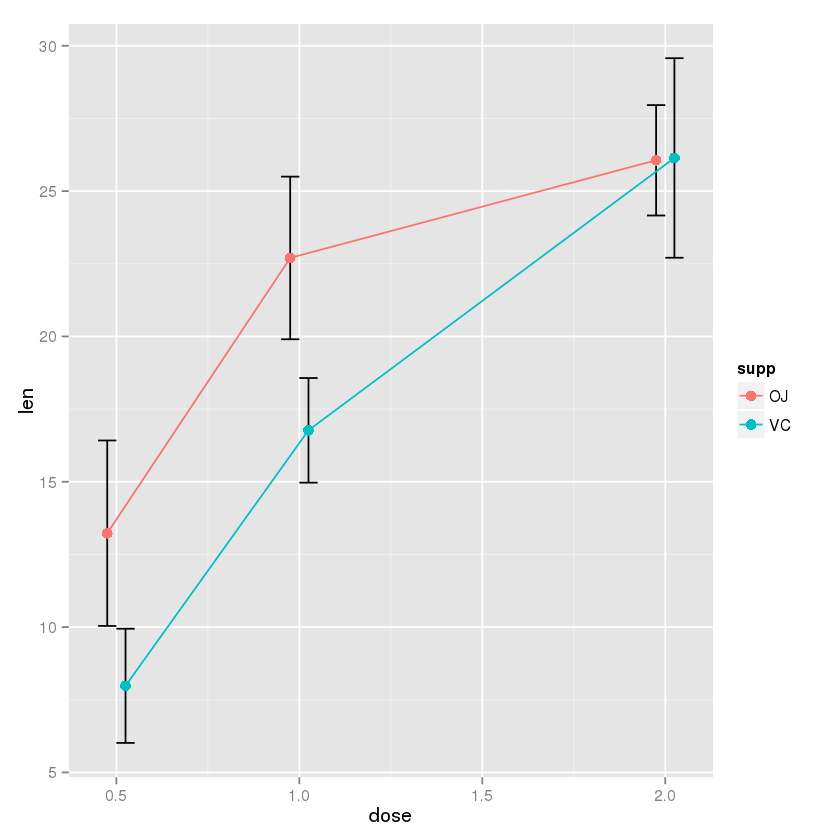

In [10]:
# Black error bars - notice the mapping of 'group=supp' -- without it, the error
# bars won't be dodged!
ggplot(tgc, aes(x=dose, y=len, colour=supp, group=supp)) + 
    geom_errorbar(aes(ymin=len-ci, ymax=len+ci), colour="black", width=.1, position=pd) +
    geom_line(position=pd) +
    geom_point(position=pd, size=3)

A finished graph with error bars representing the standard error of the mean might look like this. The points are drawn last so that the white fill goes on top of the lines and error bars.

ymax not defined: adjusting position using y instead
ymax not defined: adjusting position using y instead


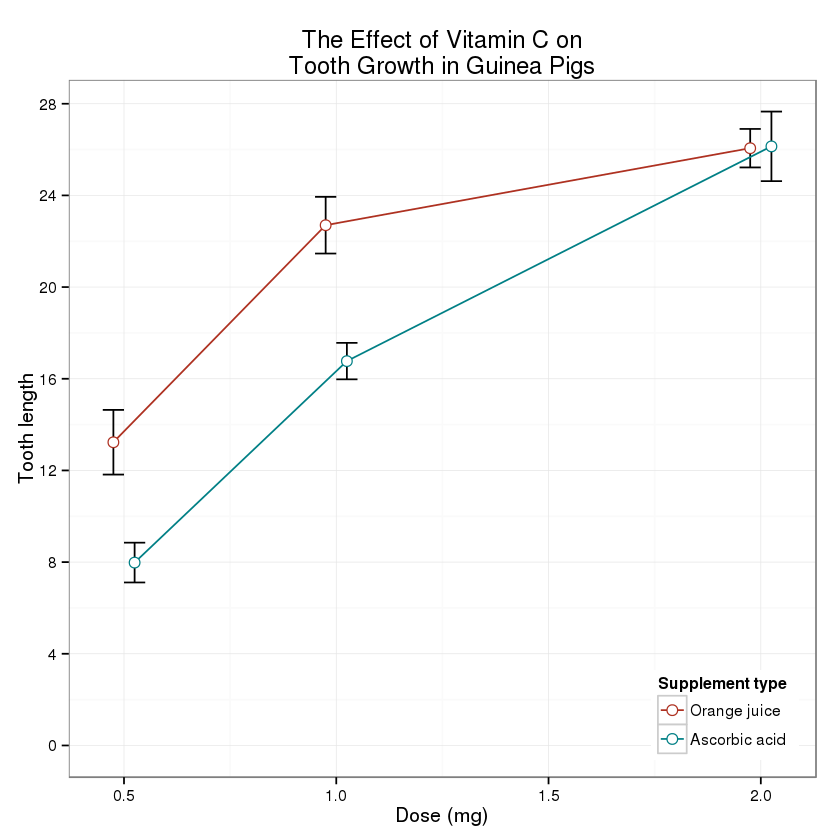

In [11]:
ggplot(tgc, aes(x=dose, y=len, colour=supp, group=supp)) + 
    geom_errorbar(aes(ymin=len-se, ymax=len+se), colour="black", width=.1, position=pd) +
    geom_line(position=pd) +
    geom_point(position=pd, size=3, shape=21, fill="white") + # 21 is filled circle
    xlab("Dose (mg)") +
    ylab("Tooth length") +
    scale_colour_hue(name="Supplement type",    # Legend label, use darker colors
                     breaks=c("OJ", "VC"),
                     labels=c("Orange juice", "Ascorbic acid"),
                     l=40) +                    # Use darker colors, lightness=40
    ggtitle("The Effect of Vitamin C on\nTooth Growth in Guinea Pigs") +
    expand_limits(y=0) +                        # Expand y range
    scale_y_continuous(breaks=0:20*4) +         # Set tick every 4
    theme_bw() +
    theme(legend.justification=c(1,0),
          legend.position=c(1,0))               # Position legend in bottom right

### Bar graphs

The procedure is similar for bar graphs. Note that `tgc$size` must be a factor. If it is a numeric vector, then it will not work.

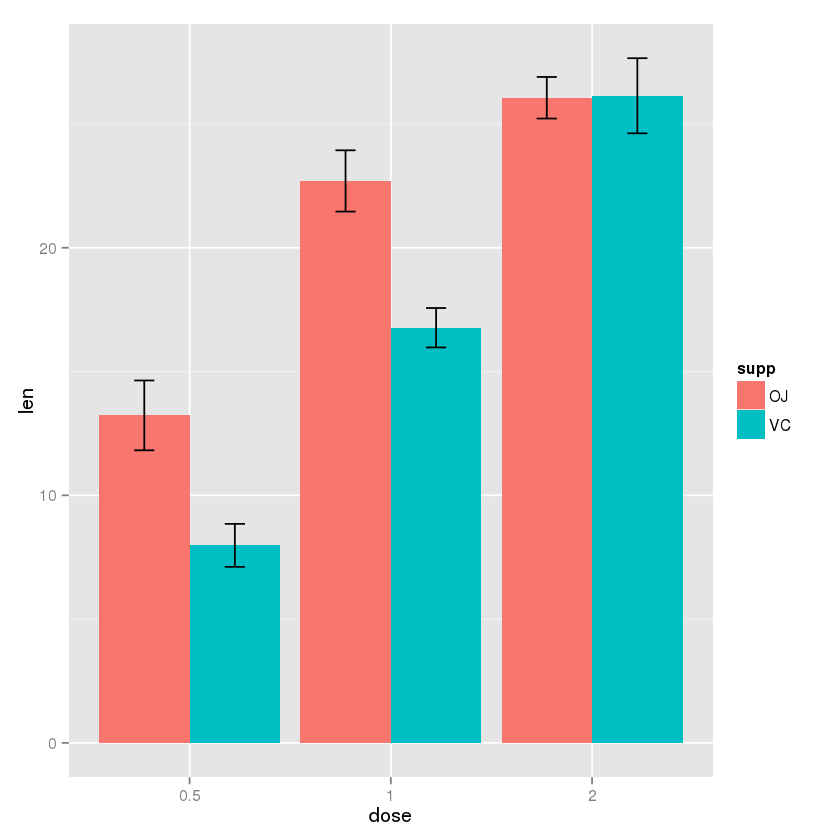

In [12]:
# Use dose as a factor rather than numeric
tgc2 <- tgc
tgc2$dose <- factor(tgc2$dose)

# Error bars represent standard error of the mean
ggplot(tgc2, aes(x=dose, y=len, fill=supp)) + 
    geom_bar(position=position_dodge(), stat="identity") +
    geom_errorbar(aes(ymin=len-se, ymax=len+se),
                  width=.2,                    # Width of the error bars
                  position=position_dodge(.9))

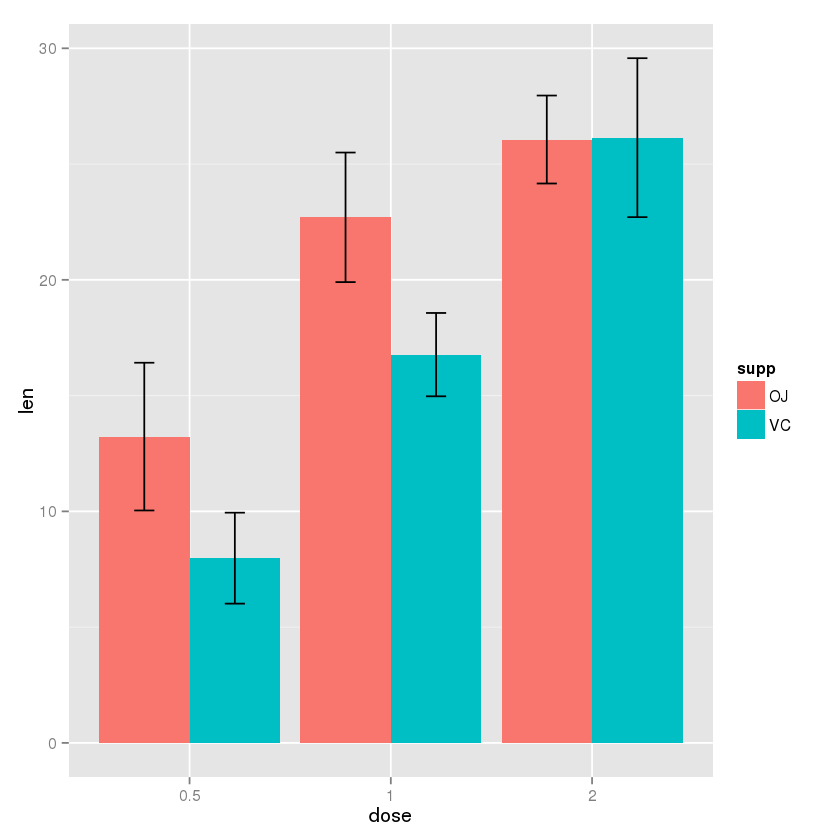

In [13]:
# Use 95% confidence intervals instead of SEM
ggplot(tgc2, aes(x=dose, y=len, fill=supp)) + 
    geom_bar(position=position_dodge(), stat="identity") +
    geom_errorbar(aes(ymin=len-ci, ymax=len+ci),
                  width=.2,                    # Width of the error bars
                  position=position_dodge(.9))

A finished graph might look like this.

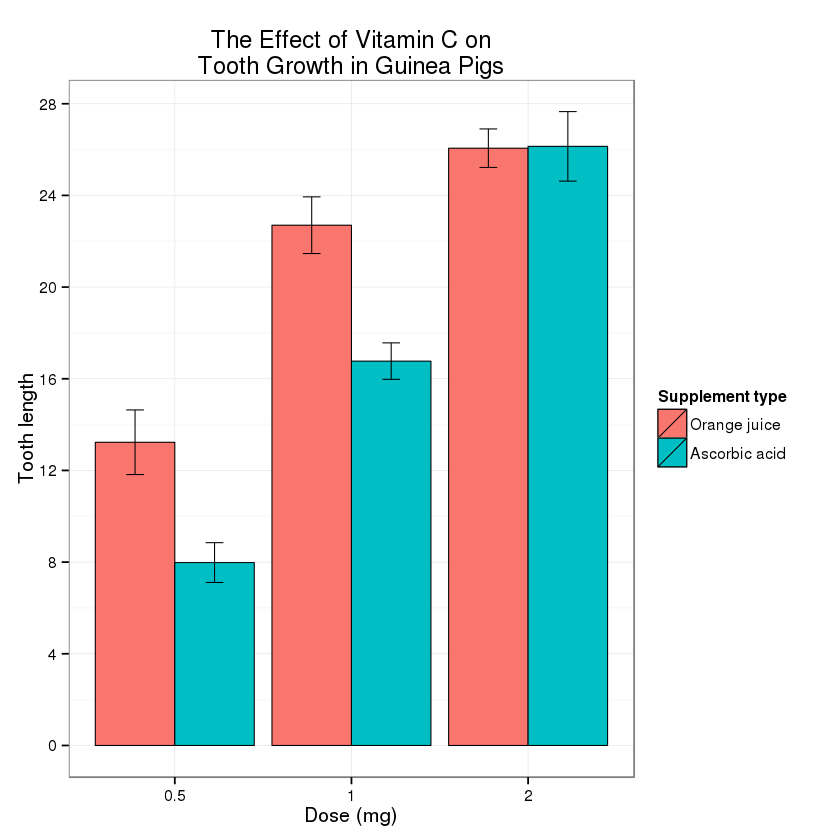

In [14]:
ggplot(tgc2, aes(x=dose, y=len, fill=supp)) + 
    geom_bar(position=position_dodge(), stat="identity",
             colour="black", # Use black outlines,
             size=.3) +      # Thinner lines
    geom_errorbar(aes(ymin=len-se, ymax=len+se),
                  size=.3,    # Thinner lines
                  width=.2,
                  position=position_dodge(.9)) +
    xlab("Dose (mg)") +
    ylab("Tooth length") +
    scale_fill_hue(name="Supplement type", # Legend label, use darker colors
                   breaks=c("OJ", "VC"),
                   labels=c("Orange juice", "Ascorbic acid")) +
    ggtitle("The Effect of Vitamin C on\nTooth Growth in Guinea Pigs") +
    scale_y_continuous(breaks=0:20*4) +
    theme_bw()

### Error bars for within-subjects variables

When all variables are between-subjects, it is straightforward to plot standard error or confidence intervals. However, when there are within-subjects variables (repeated measures), plotting the standard error or regular confidence intervals may be misleading for making inferences about differences between conditions.

The method below is from <a href="http://tqmp.org/Content/vol04-2/p061/p061.html" target="_blank" >Morey (2008)</a>, which is a correction to <a href="http://tqmp.org/Content/vol01-1/p042/p042.html" target="_blank" >Cousineau (2005)</a>, which in turn is meant to be a simpler method of that in <a href="http://www.springerlink.com/content/n2r2t04244246k68/" target="_blank">Loftus and Masson (1994)</a>. See these papers for a more detailed treatment of the issues involved in error bars with within-subjects variables.

#### One within-subjects variable

Here is a data set (from Morey 2008) with one within-subjects variable: pre/post-test.

In [15]:
dfw <- read.table(header=TRUE, text='
 subject pretest posttest
       1    59.4     64.5
       2    46.4     52.4
       3    46.0     49.7
       4    49.0     48.7
       5    32.5     37.4
       6    45.2     49.5
       7    60.3     59.9
       8    54.3     54.1
       9    45.4     49.6
      10    38.9     48.5
 ')

# Treat subject ID as a factor
dfw$subject <- factor(dfw$subject)

The first step is to convert it to long format. Search for "Converting data between wide and long format" for more information about the conversion.

In [16]:
# Convert to long format
library(reshape2)
dfw_long <- melt(dfw,
                 id.vars = "subject",
                 measure.vars = c("pretest","posttest"),
                 variable.name = "condition")

dfw_long

,subject,condition,value
1,1,pretest,59.4
2,2,pretest,46.4
3,3,pretest,46
4,4,pretest,49
5,5,pretest,32.5
6,6,pretest,45.2
7,7,pretest,60.3
8,8,pretest,54.3
9,9,pretest,45.4
10,10,pretest,38.9


Collapse the data using summarySEwithin (which is a function defined at the start of this notebook)

In [17]:
dfwc <- summarySEwithin(dfw_long, measurevar="value", withinvars="condition",
                        idvar="subject", na.rm=FALSE, conf.interval=.95)

dfwc

,condition,N,value,value_norm,sd,se,ci
1,posttest,10,51.43,51.43,2.262361,0.7154214,1.618396
2,pretest,10,47.74,47.74,2.262361,0.7154214,1.618396


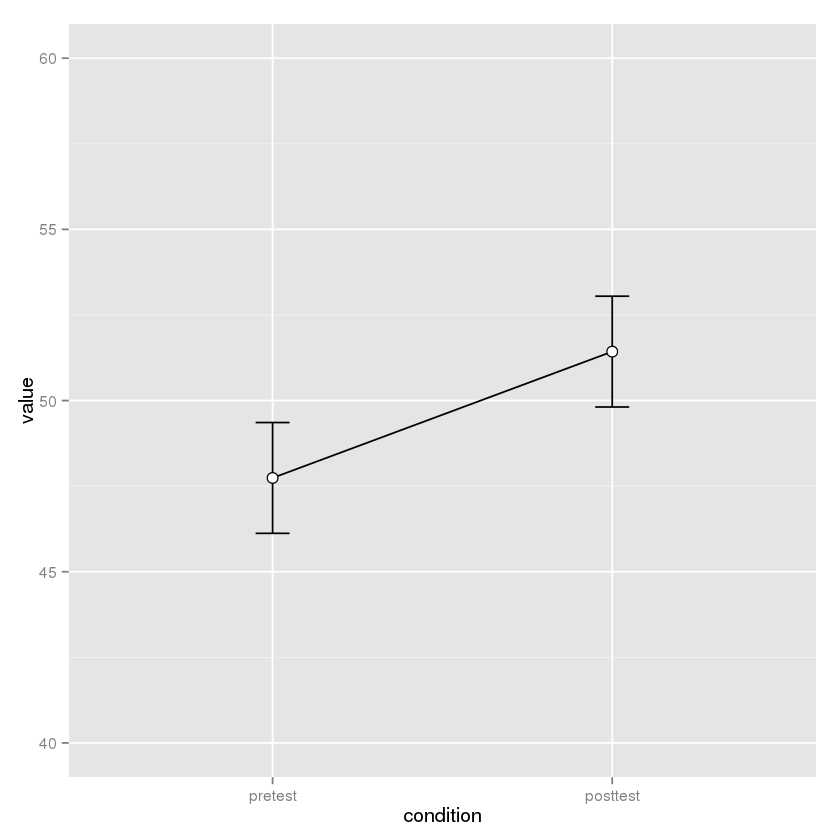

In [18]:
ggplot(dfwc, aes(x=condition, y=value, group=1)) +
    geom_line() +
    geom_errorbar(width=.1, aes(ymin=value-ci, ymax=value+ci)) +
    geom_point(shape=21, size=3, fill="white") +
    ylim(40,60)

The value and `value_norm` columns represent the un-normed and normed means. See the section below on normed means for more information.

### Understanding within-subjects error bars

This section explains how the within-subjects error bar values are calculated. The steps here are for explanation purposes only; they are not necessary for **making** the error bars.

The graph of individual data shows that there is a consistent trend for the within-subjects variable `condition`, but this would not necessarily be revealed by taking the regular standard errors (or confidence intervals) for each group. The method in Morey (2008) and Cousineau (2005) essentially normalizes the data to remove the between-subject variability and calculates the variance from this normalized data.

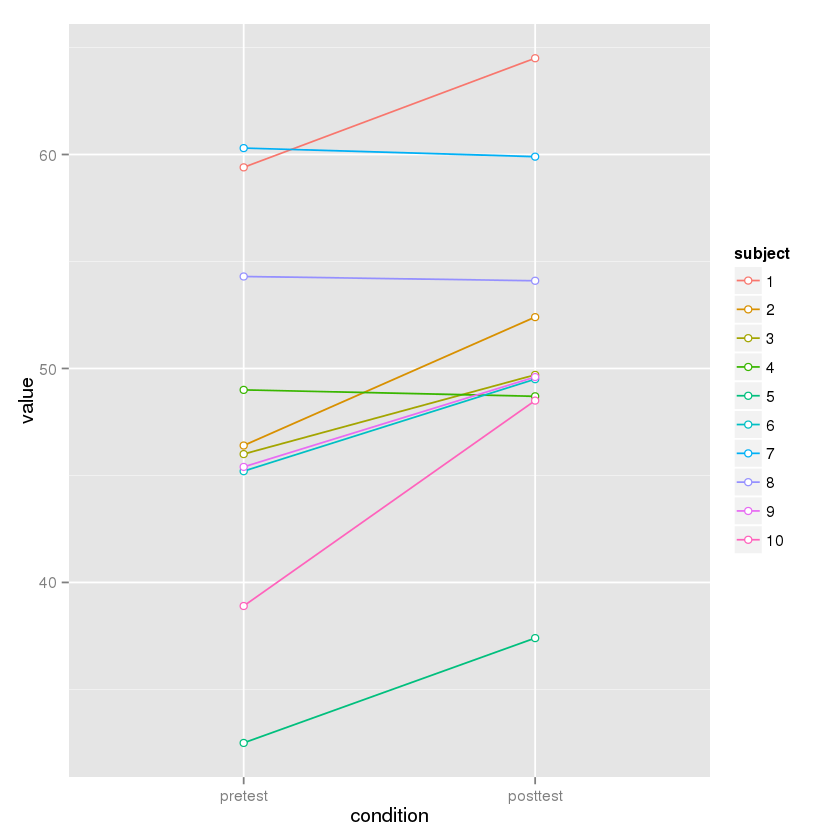

In [19]:
# Use a consistent y range
ymax <- max(dfw_long$value)
ymin <- min(dfw_long$value)

# Plot the individuals
ggplot(dfw_long, aes(x=condition, y=value, colour=subject, group=subject)) +
    geom_line() + geom_point(shape=21, fill="white") + 
    ylim(ymin,ymax)

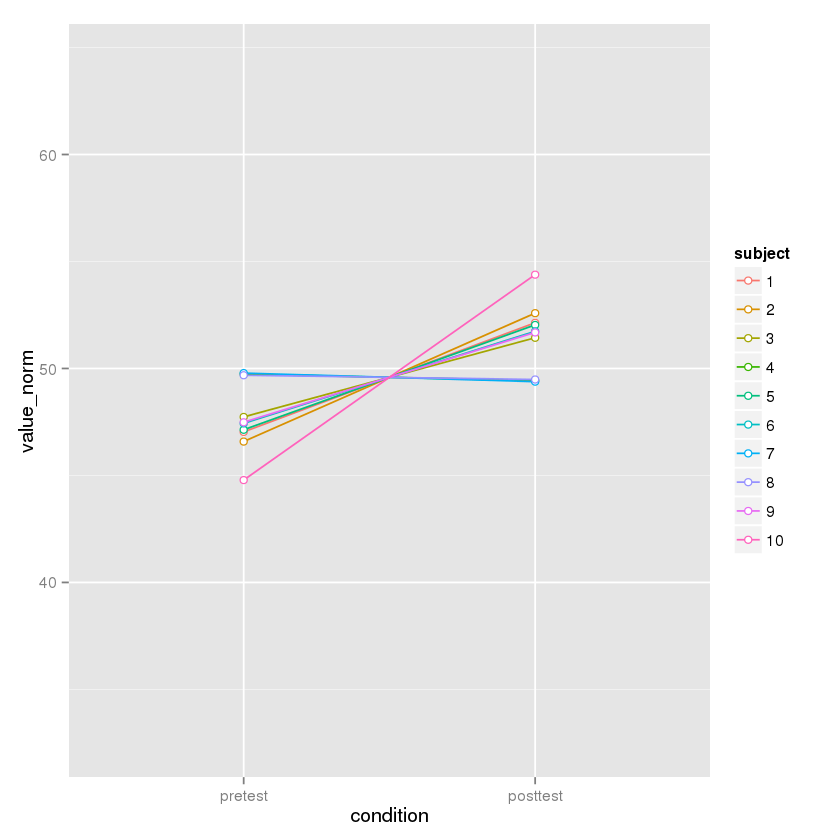

In [20]:
# Create the normed version of the data
dfwNorm.long <- normDataWithin(data=dfw_long, idvar="subject", measurevar="value")

# Plot the normed individuals
ggplot(dfwNorm.long, aes(x=condition, y=value_norm, colour=subject, group=subject)) +
    geom_line() + geom_point(shape=21, fill="white") + 
    ylim(ymin,ymax)

The differences in the error bars for the regular (between-subject) method and the within-subject method are shown here. The regular error bars are in red, and the within-subject error bars are in black.

In [21]:
# Instead of summarySEwithin, use summarySE, which treats condition as though it were a between-subjects variable
dfwc_between <- summarySE(data=dfw_long, measurevar="value", groupvars="condition", na.rm=FALSE, conf.interval=.95)
dfwc_between

,condition,N,value,sd,se,ci
1,pretest,10,47.74,8.598992,2.71924,6.151348
2,posttest,10,51.43,7.253972,2.293907,5.189179


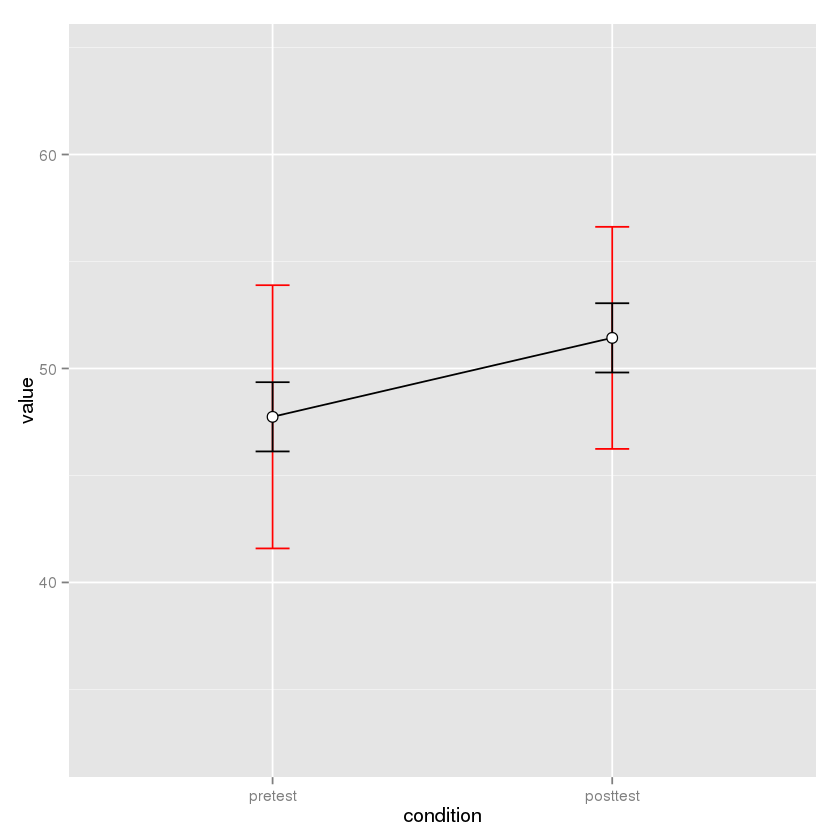

In [22]:
# Show the between-S CI's in red, and the within-S CI's in black
ggplot(dfwc_between, aes(x=condition, y=value, group=1)) +
    geom_line() +
    geom_errorbar(width=.1, aes(ymin=value-ci, ymax=value+ci), colour="red") +
    geom_errorbar(width=.1, aes(ymin=value-ci, ymax=value+ci), data=dfwc) +
    geom_point(shape=21, size=3, fill="white") +
    ylim(ymin,ymax)

### Two within-subjects variables

If there is more than one within-subjects variable, the same function, `summarySEwithin`, can be used. This data set is taken from <a href="http://books.google.com/books?id=zSi2AAAAIAAJ" target="_blank">Hays (1994)</a>, and used for making this type of within-subject error bar in <a href="http://www.jstor.org/pss/40064075" target="_blank">Rouder and Morey (2005)</a>.

In [23]:
data <- read.table(header=TRUE, text='
 Subject RoundMono SquareMono RoundColor SquareColor
       1        41         40         41          37
       2        57         56         56          53
       3        52         53         53          50
       4        49         47         47          47
       5        47         48         48          47
       6        37         34         35          36
       7        47         50         47          46
       8        41         40         38          40
       9        48         47         49          45
      10        37         35         36          35
      11        32         31         31          33
      12        47         42         42          42
')

The data must first be converted to long format. In this case, the column names indicate two variables, shape (round/square) and color scheme (monochromatic/colored).

In [24]:
data_long <- melt(data=data, id.var="Subject",
                  measure.vars=c("RoundMono", "SquareMono", "RoundColor", "SquareColor"),
                  variable.name="Condition")
names(data_long)[names(data_long)=="value"] <- "Time"

# Split Condition column into Shape and ColorScheme
data_long$Shape <- NA
data_long$Shape[grepl("^Round",  data_long$Condition)] <- "Round"
data_long$Shape[grepl("^Square", data_long$Condition)] <- "Square"
data_long$Shape <- factor(data_long$Shape)

data_long$ColorScheme <- NA
data_long$ColorScheme[grepl("Mono$",  data_long$Condition)] <- "Monochromatic"
data_long$ColorScheme[grepl("Color$", data_long$Condition)] <- "Colored"
data_long$ColorScheme <- factor(data_long$ColorScheme, levels=c("Monochromatic","Colored"))

# Remove the Condition column now
data_long$Condition <- NULL

# Look at first few rows 
head(data_long)

,Subject,Time,Shape,ColorScheme
1,1,41,Round,Monochromatic
2,2,57,Round,Monochromatic
3,3,52,Round,Monochromatic
4,4,49,Round,Monochromatic
5,5,47,Round,Monochromatic
6,6,37,Round,Monochromatic


Now it can be summarized and graphed.

In [25]:
datac <- summarySEwithin(data_long, measurevar="Time", withinvars=c("Shape","ColorScheme"), idvar="Subject")
datac

,Shape,ColorScheme,N,Time,Time_norm,sd,se,ci
1,Round,Colored,12,43.58333,43.58333,1.212311,0.3499639,0.7702654
2,Round,Monochromatic,12,44.58333,44.58333,1.331438,0.3843531,0.8459554
3,Square,Colored,12,42.58333,42.58333,1.46163,0.4219364,0.9286757
4,Square,Monochromatic,12,43.58333,43.58333,1.261312,0.3641095,0.8013997


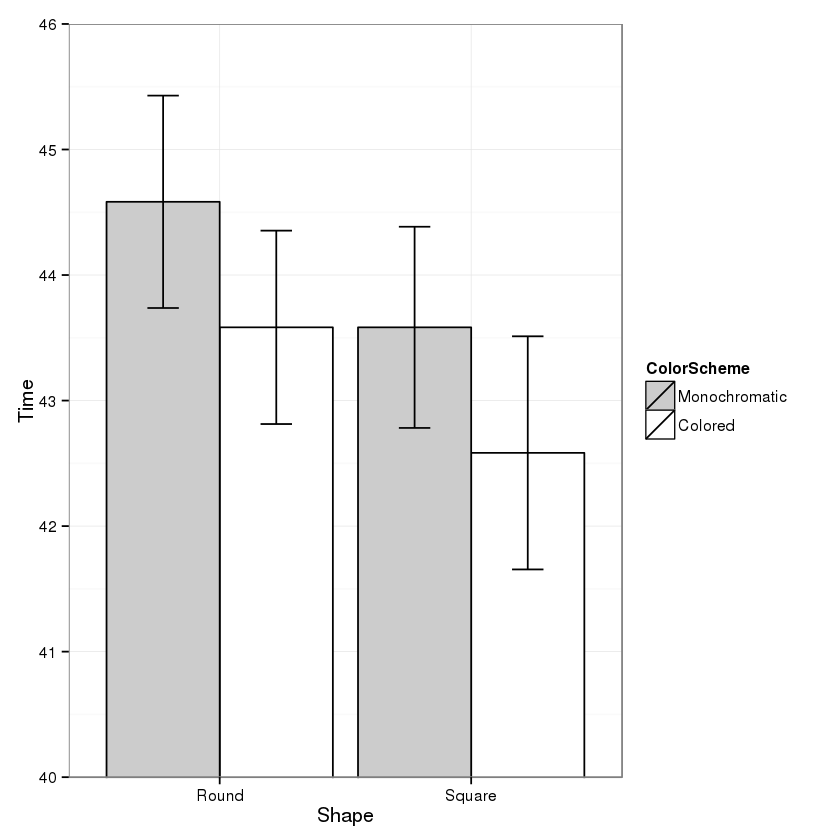

In [26]:
library(ggplot2)
ggplot(datac, aes(x=Shape, y=Time, fill=ColorScheme)) +
    geom_bar(position=position_dodge(.9), colour="black", stat="identity") +
    geom_errorbar(position=position_dodge(.9), width=.25, aes(ymin=Time-ci, ymax=Time+ci)) +
    coord_cartesian(ylim=c(40,46)) +
    scale_fill_manual(values=c("#CCCCCC","#FFFFFF")) +
    scale_y_continuous(breaks=seq(1:100)) +
    theme_bw() +
    geom_hline(yintercept=38) 

### Note about normed means

The `summarySEWithin` function returns both normed and un-normed means. The un-normed means are simply the mean of each group. The normed means are calculated so that means of each between-subject group are the same. These values can diverge when there are between-subject variables.

For example:

In [27]:
dat <- read.table(header=TRUE, text='
id trial gender dv
 A     0   male  2
 A     1   male  4
 B     0   male  6
 B     1   male  8
 C     0 female 22
 C     1 female 24
 D     0 female 26
 D     1 female 28
')

# normed and un-normed means are different
summarySEwithin(dat, measurevar="dv", withinvars="trial", betweenvars="gender",
                idvar="id")

Automatically converting the following non-factors to factors: trial


,gender,trial,N,dv,dv_norm,sd,se,ci
1,female,0,2,24,14,0,0,0
2,female,1,2,26,16,0,0,0
3,male,0,2,4,14,0,0,0
4,male,1,2,6,16,0,0,0
